# Project Data Engineering

Data Engineering - TIF A

Kelompok 5:
- Aldi Fianda Putra - 195150201111034
- Riski Darmawan - 195150200111039
- Hasyir Daffa Ibrahim - 195150207111039

**Deskripsi Project**

1. Ambil Datasource (Data Primer / Data Sekunder)
2. Lakukan Proses ETL
> 1. Sesuaikan schema
> 2. Lakukan data pre-processing
> 3. Gunakan Great expectation untuk data validation
> 4. Masukkan ke DB (mysql, sqlite3, postgre, mongodb)
> 5. Ambil subsetdata dari DB (Datamart)
3. Lakukan Proses Exploratory Data Analysis
4. Lakukan proses Machine Learning
5. (Optinoal: Nilai +) Buat Dashboard (Hasil Exploratory Data Analysis, Modeling)
6. (Optional: Nilai +) Buat Scheduling
7. Evaluasi Hasil

.

Persiapkan:
- PPT
- Demo
- Source code
- Video
> - Konfigurasi (Kafka, API, DB, docker, kubernetes, dll)
> - Demo implementasi

## **Topic: Windows 11**


# 1. Installasi dan Konfigurasi Airflow

Berikut ini adalah prosedur installasi airflow sebelum masuk ke dalam pembahasan scheduling data:
1. Pastikan menggunakan environment linux seperti Ubuntu, Arch dan lain-lain. Pada percobaan ini kami menggunakan linux dengan distro Manjaro yang merupakan turunan Arch. 
2. Install python-pip terlebih dahulu dengan menggunakan perintah sudo apt-get install python-pip, sedangkan pada perangkat kami karena menggunakan Arch-based maka menggunakan perintah sudo pacman -S python-pip ataupun yay -S python-pip
3. Install depedensi yang dibutuhkan airflow seperti libmysqlclient-dev, libssl-dev, libkrb5-dev ataupun depedensi lainnya mengikuti error yang akan muncul nantinya.
4. Buat database baru dengan menggunakan perintah airflow db init.
5. Jalankan perintah airflow webserver -p 8080, kemudian jalankan juga airflow scheduler namun pada terminal yang berbeda
6. Buat sebuah akun untuk airflow dengan urutan airflow users create [-h] -e EMAIL -f FIRSTNAME -l LASTNAME [-p PASSWORD] -r                  ROLE [--use-random-password] -u USERNAME,
7. Buka web browser pada alamat localhost:8080, kemudian login dan apabila diperoleh tampilan UI Airflow berarti siap digunakan.
8. Karena pada percobaan ini melakukan stream data, maka jalankan kafka dan zookeeper terlebih dahulu melalui direktori kafka

## Nomor 2 sampai dengan 5 berikut tidak dijalankan melalui notebook

# 2. Streaming Data

In [ ]:
# import library
import tweepy
from kafka import KafkaProducer
from datetime import datetime, timedelta
import csv
import pandas as pd

consumer_key = "Gg0FYnVBi1a9MeVR4cd7iBIHH"
consumer_secret = "i3whWfXsPi5uNjAXwskSQKmZobfgezo4SmK4R8hfL6WkWZGfdM"
access_token = "818938632782299136-VM0HUdQzBHdWsaWkXIfStkzSoKzRa0L"
access_token_secret = "IcKhsxWvCnLVqp2iigRw4tdNVqMsxFNWkGt5kXfQKhcfH"

# setup autentikasi
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

# instansiasi API
api = tweepy.API(auth, wait_on_rate_limit=True)

# menyesuaikan waktu dengan waktu lokal (GMT +7 / UTC +7)
def normalize_time(time):
    mytime = datetime.strptime(time, "%Y-%m-%d %H:%M:%S")
    mytime += timedelta(hours=7)
    return (mytime.strftime("%Y-%m-%d %H:%M:%S"))

# instansiasi Kafka Producer
producer = KafkaProducer(bootstrap_servers=['localhost:9092'], api_version=(0, 10, 1))

# inisialisasi topik, kata kunci, serta batas maksimum query dan tweet
topic_name = 'windows_11'
search_key = "windows 11"
maxId = -1
maxTweets = 3000
tweetCount = 0
tweetsPerQuery = 200

# deklarasi file csv
csvFile = open(search_key+".csv", "a+", newline="", encoding="utf-8")
csvWriter = csv.writer(csvFile)

# deklarasi list
tweet_id = []
tweet_username = []
tweet_text = []

# perulangan untuk mendapatkan tweet dengna API Twitter hingga limit yang ditentukan
while tweetCount < maxTweets:
    # mengambil data tweet pertama kali
    if maxId <= 0:
        # newTweets = api.search_tweets(q=search_key, lang="en", count=tweetCount, max_id=maxId)
        newTweets = api.search_tweets(q=search_key, lang="id", count=tweetCount)
    # mengambil data tweet kedua dan seterusnya
    newTweets = api.search_tweets(q=search_key, lang="id", count=tweetsPerQuery)

    # mengambil atribut tertentu dari suatu tweet
    for i in newTweets:
        record = str(i.user.id_str)
        record += ';'
        record = str(i.user.name)
        record += ';'
        # record += str(normalize_timestamp(str(i.created_at)))
        # record += ';'
        # record += str(i.full_text.encode('utf-8'))
        record += str(i.text.encode('utf-8'))
        record += ';'
        print(str.encode(record))
        producer.send(topic_name, str.encode(record))

        tweet_id.append(str(i.user.id_str))
        tweet_username.append(str(i.user.name))
        tweet_text.append(str(i.text.encode('utf-8')))
        tweets = [str(i.user.id_str), str(i.user.name), str(i.text.encode('utf-8'))]
        csvWriter.writerow(tweets)

    # menambah jumlah TweetCount dan MaxId
    tweetCount += len(newTweets)
    maxId = newTweets[-1].id

# mencoba mencetak
dictTweets = {"id":tweet_id, "username":tweet_username, "text":tweet_text}
df = pd.DataFrame(dictTweets)
# df


# 3. Extract Data

In [ ]:
import pandas as pd
kolom = ['id', 'username', 'tweet']
#Direktori dapat disesuaikan dengan tempat path tempat file python, csv dan db disimpan
df_windows = pd.read_csv('/home/stndb01/Documents/Data_Engineering/Proyek/windows 11.csv', names = kolom)
df_windows
df_windows.duplicated().value_counts()

df_windows.to_csv('/home/stndb01/Documents/Data_Engineering/Proyek/windows_11_e.csv')


# 4. Transform

In [ ]:
import pandas as pd
kolom = ['id', 'username', 'tweet']
df_windows = pd.read_csv('/home/stndb01/Documents/Data_Engineering/Proyek/windows_11_e.csv', names = kolom)
#df_windows.duplicated().value_counts()


df_windows.drop_duplicates(inplace=True, ignore_index=True)
df_windows
df_windows.to_csv('/home/stndb01/Documents/Data_Engineering/Proyek/windows_11_t.csv')

# 5. Load

In [ ]:
import sqlite3 as s3
import pandas as pd
import os

# membuat koneksi ke database
conn = s3.connect('/home/stndb01/Documents/Data_Engineering/Proyek/windows11_data.db')

# Object cursor untuk menjalankan perintah SQL
cur = conn.cursor()

# load dataframe ke datamart
df_windows = pd.read_csv('/home/stndb01/Documents/Data_Engineering/Proyek/windows_11_t.csv')
df_windows.to_sql('windows11_table',conn,if_exists='replace',index=False)
os.remove("/home/stndb01/Documents/Data_Engineering/Proyek/windows_11_e.csv")
os.remove("/home/stndb01/Documents/Data_Engineering/Proyek/windows_11_t.csv")

In [ ]:
query = '''select * from windows11_table'''
pd.read_sql(query, conn)

# 6. Scheduling

In [ ]:
from datetime import timedelta
from airflow.operators.bash import BashOperator
from airflow.utils.dates import days_ago
from airflow import DAG

default_args = {
    'owner': 'admin',
    'depends_on_past': False,
    'email': ['airflow@example.com'],
    'email_on_failure': False,
    'email_on_retry': False,
    'retries': 1,
}
with DAG(
    'Proyek_Akhir',
    default_args=default_args,
    description='Scheduling untuk task proyek akhir',
    schedule_interval=timedelta(days=1),
    start_date=days_ago(2),
    tags=['proyek'],
) as dag:

    stream        = BashOperator(
                    task_id='Stream_data_twitter',
                    bash_command='python /home/stndb01/Documents/Data_Engineering/Proyek/stream.py'
                    #bash_command='python stream.py',
                    )

    extract        = BashOperator(
                    task_id='Extract_data_twitter',
                    bash_command='python /home/stndb01/Documents/Data_Engineering/Proyek/extract.py'
                    #bash_command='python extract.py',
                    )

    transform        = BashOperator(
                    task_id='Transform_data_twitter',
                    bash_command='python /home/stndb01/Documents/Data_Engineering/Proyek/transform.py'
                    #bash_command='python transform.py',
                    )

    load        = BashOperator(
                    task_id='Load_data_twitter',
                    bash_command='python /home/stndb01/Documents/Data_Engineering/Proyek/load.py'
                    #bash_command='python load.py',
                    )

    stream.set_downstream(extract)
    extract.set_downstream(transform)
    transform.set_downstream(load)




In [1]:
import sqlite3 as s3
import pandas as pd
import os

# membuat koneksi ke database
conn = s3.connect('windows11_data.db')

# Object cursor untuk menjalankan perintah SQL
cur = conn.cursor()
query = '''select * from windows11_table limit 10'''
pd.read_sql(query, conn)

,id,username,tweet
0,60951089,桜木李杏🌸🍲🦊C99_1日目「メ36a」委託/2日目「に35a」,"b""RT @lockheimer: We're bringing Play Games to..."
1,1408009628764585984,theolreverendsburner,b'@Macauley_Tonna @Halo My 2 cents: do a clean...
2,1082920971114332160,Ricoh eShop UK,b'*PRODUCT*\n\nThe Lenovo notebook Laptops wit...
3,2198733733,Cleodesktop,b'After Dark Gray Theme For Windows 11 - \nGet...
4,1052557647856189441,Beyte Fyr,"b""Should I upgrade to Windows 11? I'm angsty a..."
5,741271705419681792,Pureinfotech (feed),b'Pantone Color of the Year 2022 theme for Win...
6,153375516,Marcus Griffiths,b'RT @CRecyclers: *LIMITED AVAILABILITY* \nWin...
7,1005087587923419137,いまおか,b'As the availability of new PC processors and...
8,1441080293364879375,Vinay Kishore,b'Arggggg\xf0\x9f\x98\xa1.......Everything in ...
9,3064146644,SATYAJIT GHOSH ,b'RT @MicrosoftHelps: It might not come with a...


# 7. Machine Learning - Sentiment Analysis

## 7.1. Read Data

In [2]:
# konstanta topik
TOPIC = "Windows 11"

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sqlite3 as s3

import re
import codecs

In [4]:
# membuat koneksi ke database
conn = s3.connect('windows11_data.db')

# Object cursor untuk menjalankan perintah SQL
cur = conn.cursor()
query = '''select * from windows11_table'''
df = pd.read_sql(query, conn)
df

,id,username,tweet
0,60951089,桜木李杏🌸🍲🦊C99_1日目「メ36a」委託/2日目「に35a」,"b""RT @lockheimer: We're bringing Play Games to..."
1,1408009628764585984,theolreverendsburner,b'@Macauley_Tonna @Halo My 2 cents: do a clean...
2,1082920971114332160,Ricoh eShop UK,b'*PRODUCT*\n\nThe Lenovo notebook Laptops wit...
3,2198733733,Cleodesktop,b'After Dark Gray Theme For Windows 11 - \nGet...
4,1052557647856189441,Beyte Fyr,"b""Should I upgrade to Windows 11? I'm angsty a..."
...,...,...,...
100,2281129274,Mehmet,b'Windows 11 Features #1 Color Filters\n#Windo...
101,2571317438,鳥麦康人(とりむぎやすと),"b""RT @lockheimer: We're bringing Play Games to..."
102,1274775491006922752,Ash Collins 🏴󠁧󠁢󠁷󠁬󠁳󠁿,b'So I had a look at windows 11 the other day ...
103,3064146644,SATYAJIT GHOSH ,b'RT @androidcodex: So I had a look at windows...


## 7.2. Preprocessing

### 7.2.1. Cleaning Text Data

In [5]:
def preprocess_text(review):
    # using regex to replace
    review = codecs.decode(review, 'unicode_escape') #remove escape character
    review = review[2:-1]
    review = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL', review)
    review = re.sub('[^\x00-\x7f]', '', review) 
    review = re.sub('@[^\s]+','USER', review)
    review = review.lower().replace("ё", "е")
    review = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', review)
    review = re.sub(' +',' ', review)
    return review.strip()

In [6]:
df['tweet'] = [preprocess_text(review) for review in df['tweet']]

## 7.3. Sentiment Analysis using Text Blob

### 7.3.1. Get Sentiment

Bekerja dengan baik pada data text yang berbahasa Inggris

In [7]:
from textblob import TextBlob

def sentiment_analysis(data):
  def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

  #Create a function to get the polarity
  def getPolarity(text):
    return TextBlob(text).sentiment.polarity

  def getAnalysis(score):
    if score < 0:
      return "Negative"
    elif score == 0:
      return "Neutral"
    else:
      return "Positive"

  #Create two new columns 'Subjectivity' & 'Polarity'
  data["TextBlob_Subjectivity"] = data["tweet"].apply(getSubjectivity)
  data["TextBlob_Polarity"] = data["tweet"].apply(getPolarity)

  data["TextBlob_Analysis"] = data["TextBlob_Polarity"].apply(getAnalysis)
  return data

In [8]:
df = sentiment_analysis(df)
df

,id,username,tweet,TextBlob_Subjectivity,TextBlob_Polarity,TextBlob_Analysis
0,60951089,桜木李杏🌸🍲🦊C99_1日目「メ36a」委託/2日目「に35a」,rt user we re bringing play games to windows 1...,0.662500,0.181250,Positive
1,1408009628764585984,theolreverendsburner,user user my 2 cents do a clean windows 11 ins...,0.700000,0.366667,Positive
2,1082920971114332160,Ricoh eShop UK,product the lenovo notebook laptops with new w...,0.427273,0.268182,Positive
3,2198733733,Cleodesktop,after dark gray theme for windows 11 get it he...,0.400000,-0.150000,Negative
4,1052557647856189441,Beyte Fyr,should i upgrade to windows 11 i m angsty abou...,0.000000,0.000000,Neutral
...,...,...,...,...,...,...
100,2281129274,Mehmet,windows 11 features 1 color filters windows11 ...,0.000000,0.000000,Neutral
101,2571317438,鳥麦康人(とりむぎやすと),rt user we re bringing play games to windows 1...,0.662500,0.181250,Positive
102,1274775491006922752,Ash Collins 🏴󠁧󠁢󠁷󠁬󠁳󠁿,so i had a look at windows 11 the other day an...,0.458333,-0.208333,Negative
103,3064146644,SATYAJIT GHOSH ,rt user so i had a look at windows 11 the othe...,0.458333,-0.208333,Negative


### 7.3.2. Get Most Frequent 20 words from Tweet

In [9]:
from collections import Counter

def getMostFrequentWord(df):
    most_freq = Counter(" ".join(df["tweet"]).split()).most_common(30)

    most_freq_filtered = {}
    for i in most_freq:
        if(i[0] == 'user' or i[0] == 'url' or i[0] == 'rt'):
            continue
        else:
            most_freq_filtered[i[0]] = i[1]
            if(len(most_freq_filtered) == 20): # ambil 20 kata paling banyak muncul
                break

    return most_freq_filtered

In [10]:
most_freq = getMostFrequentWord(df)
most_freq

{'windows': 104,
 '11': 92,
 'to': 57,
 'and': 39,
 'the': 39,
 'is': 29,
 '1': 25,
 'a': 22,
 'on': 22,
 'it': 22,
 'i': 20,
 'microsoft': 17,
 'you': 16,
 'like': 16,
 'games': 15,
 'with': 15,
 'so': 15,
 'of': 15,
 'google': 15,
 'play': 14}

# 8. Dashboard

Rencana data yang akan ditampilkan:

1. Identifikasi perspektif pengguna twitter terhadap kata kunci
2. Kata yang sering muncul berdasarkan kata kunci

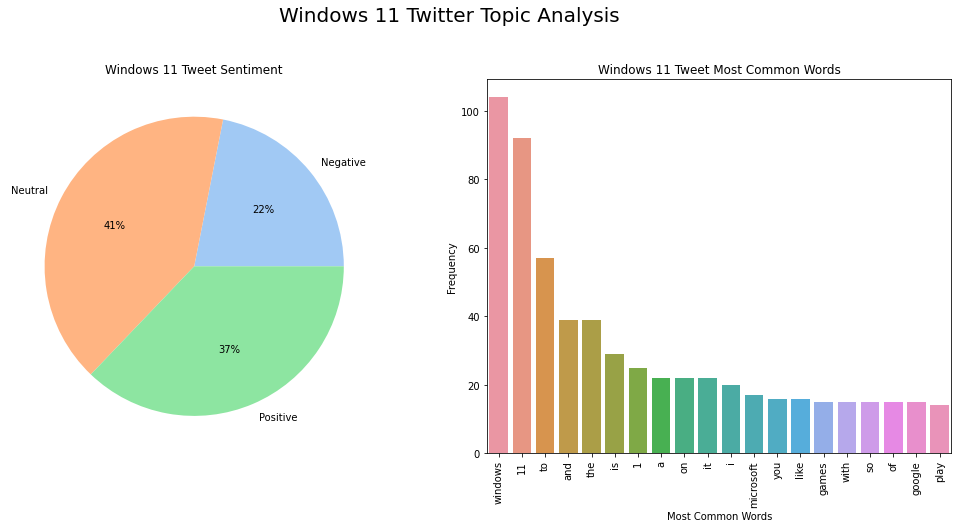

In [11]:
f, axes = plt.subplots(1, 2, figsize = (15, 7))
# sns.set_style("white")
colors = sns.color_palette('pastel')[0:5]
# colors = sns.color_palette('bright')[0:5]
f.suptitle("{} Twitter Topic Analysis".format(TOPIC), fontsize=20)
f.tight_layout(pad=3.0)

# figure 1
ax1 = plt.subplot2grid((1,2),(0,0))
ax1.title.set_text("{} Tweet Sentiment".format(TOPIC))
fig1 = plt.pie(df.groupby("TextBlob_Analysis").size(), labels = df.groupby("TextBlob_Analysis").size().index, colors = colors, autopct='%.0f%%')

# figure 2
ax2 = plt.subplot2grid((1,2),(0,1))
ax2.title.set_text("{} Tweet Most Common Words".format(TOPIC))
fig2 = sns.barplot(x=list(most_freq.keys()), y=list(most_freq.values()))
fig2.set(xlabel='Most Common Words', ylabel='Frequency')
for item in fig2.get_xticklabels():
    item.set_rotation(90)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b8e11c0c-7fdf-4dfd-b1a7-95ec2bc1e25d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>